# 2021-10-27 Multigrid

## Last time

* Domain decomposition as a framework
* Asymptotics for one-level methods
  * constants, exact and inexact subdomain solves
  
## Today

* Multigrid as a domain decomposition method
* Smoothers and coarse correction as complementary
* Local Fourier Analysis
* Principles of smoothed aggregation

In [3]:
using Plots
using LinearAlgebra
using SparseArrays

default(linewidth=4)

function advdiff_matrix(n; kappa=1, wind=[0, 0])
    "Advection-diffusion with Dirichlet boundary conditions eliminated"
    h = 2 / (n + 1)
    rows = Vector{Int64}()
    cols = Vector{Int64}()
    vals = Vector{Float64}()
    idx((i, j),) = (i-1)*n + j
    in_domain((i, j),) = 1 <= i <= n && 1 <= j <= n
    stencil_advect = [-wind[1], -wind[2], 0, wind[1], wind[2]] / h
    stencil_diffuse = [-1, -1, 4, -1, -1] * kappa / h^2
    stencil = stencil_advect + stencil_diffuse
    for i in 1:n
        for j in 1:n
            neighbors = [(i-1, j), (i, j-1), (i, j), (i+1, j), (i, j+1)]
            mask = in_domain.(neighbors)
            append!(rows, idx.(repeat([(i,j)], 5))[mask])
            append!(cols, idx.(neighbors)[mask])
            append!(vals, stencil[mask])
        end
    end
    sparse(rows, cols, vals)
end

function my_spy(A)
    cmax = norm(vec(A), Inf)
    s = max(1, ceil(120 / size(A, 1)))
    spy(A, marker=(:square, s), c=:diverging_rainbow_bgymr_45_85_c67_n256, clims=(-cmax, cmax))
end

my_spy (generic function with 1 method)

# Geometric multigrid and the spectrum

Multigrid uses a hierarchy of scales to produce an operation "$M^{-1}$" that can be applied in $O(n)$ ("linear") time and such that $\lVert I - M^{-1} A \rVert \le \rho < 1$ independent of the problem size.
We'll consider the one dimensional Laplacian using the stencil
$$ \Big(\frac{h^2}{2}\Big) \frac{1}{h^2} \begin{bmatrix} -1 & 2 & -1 \end{bmatrix} $$

In [150]:
function laplace1d(n)
    "1D Laplacion with Dirichlet boundary conditions eliminated"
    h = 2 / (n + 1)
    x = LinRange(-1, 1, n+2)[2:end-1]
    A = diagm(0 => ones(n),
        -1 => -.5*ones(n-1),
        +1 => -.5*ones(n-1))
    x, Hermitian(A)
end

laplace1d (generic function with 1 method)

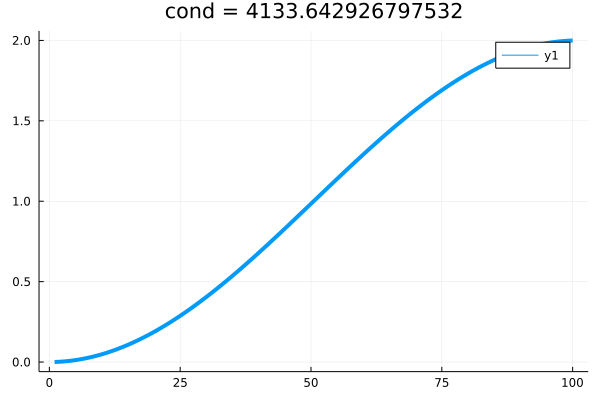

In [152]:
x, A = laplace1d(100)
L, X = eigen(A)
#@show L[1:2]
#@show L[end-2:end]
plot(L, title="cond = $(L[end]/L[1])")

# What do the eigenvectors look like?

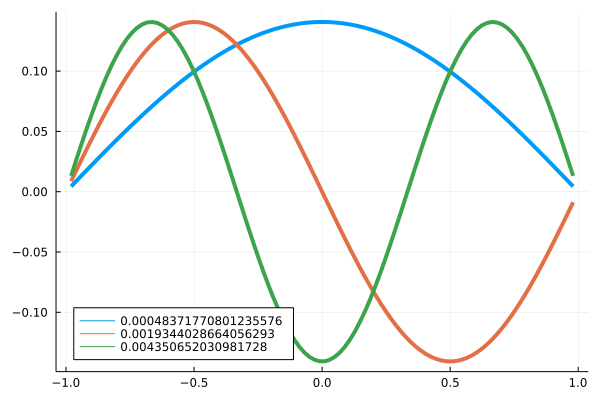

In [153]:
x, A = laplace1d(100)
L, X = eigen(A)
plot(x, X[:,1:3], label=L[1:3]', legend=:bottomleft)

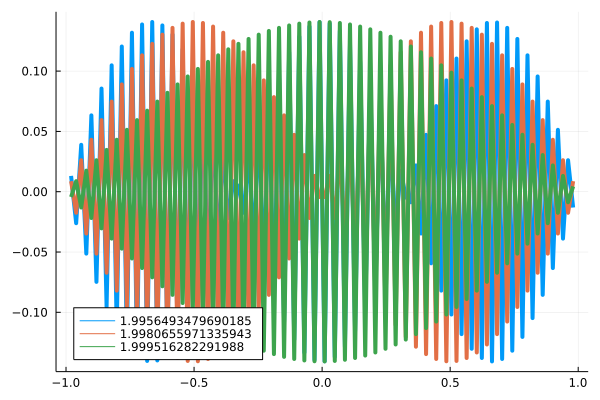

In [154]:
plot(x, X[:, end-2:end], label=L[end-2:end]', legend=:bottomleft)

# Condition number grows with grid refinement

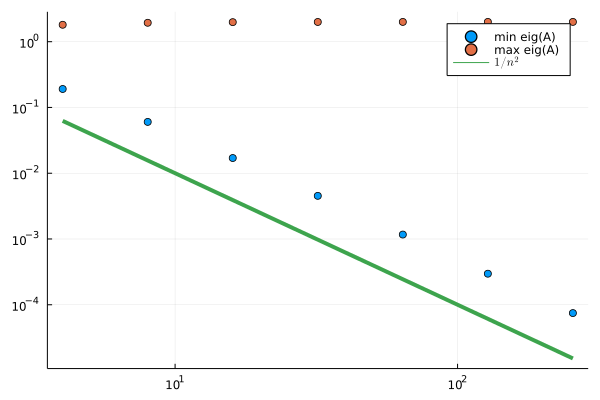

In [155]:
ns = 2 .^ (2:8)
eigs = vcat([eigvals(laplace1d(n)[2])[[1, end]] for n in ns]'...)

scatter(ns, eigs, label=["min eig(A)" "max eig(A)"])
plot!(n -> 1/n^2, label="\$1/n^2\$", xscale=:log10, yscale=:log10)

# Fourier analysis perspective

Consider the basis $\phi(x, \theta) = e^{i \theta x}$.  If we choose the grid $x \in h \mathbb Z$ with grid size $h$ then we can resolve frequencies $\lvert \theta \rvert \le \pi/h$.

In [156]:
function symbol(S, theta)
    if length(S) % 2 != 1
        error("Length of stencil must be odd")
    end
    w = length(S) ÷ 2
    phi = exp.(1im * (-w:w) * theta')
    vec(S * phi) # not! (S * phi)'
end

function plot_symbol(S, deriv=2; plot_ref=true, n_theta=30)
    theta = LinRange(-pi, pi, n_theta)
    sym = symbol(S, theta)
    rsym = real.((-1im)^deriv * sym)
    fig = plot(theta, rsym, marker=:circle, label="stencil")
    if plot_ref
        plot!(fig, th -> th^deriv, label="exact")
    end
    fig
end

plot_symbol (generic function with 4 methods)

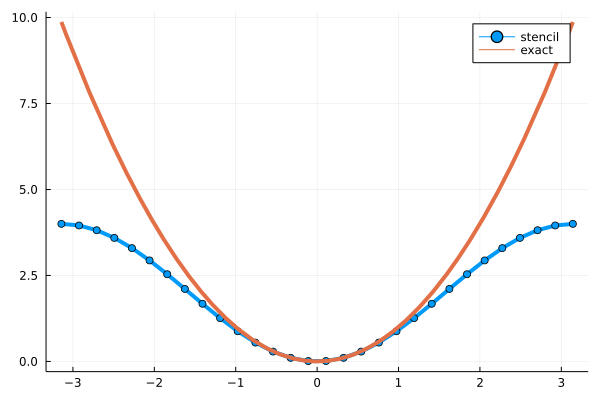

In [159]:
plot_symbol([1 -2 1])
#plot!(xlims=(-1, 1))

# Analytically computing smallest eigenvalue

The longest wavelength for a domain size of 2 with Dirichlet boundary conditions is 4. The frequency is $\theta = 2\pi/\lambda = \pi/2$. The `symbol` function works on an integer grid. We can transform via $\theta \mapsto \theta h$.

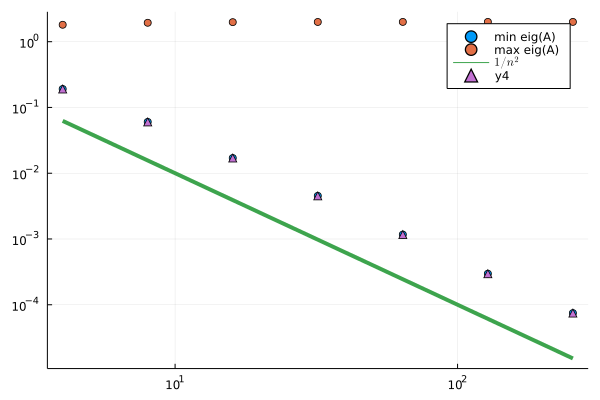

In [160]:
scatter(ns, eigs, label=["min eig(A)" "max eig(A)"])
plot!(n -> 1/n^2, label="\$1/n^2\$", xscale=:log10, yscale=:log10)
theta_min = pi ./ (ns .+ 1)
symbol_min = -real(symbol([1 -2 1], theta_min))
scatter!(ns, symbol_min / 2, shape=:utriangle)

# Damping properties of Richardson/Jacobi relaxation

Recall that we would like for $I - w A$ to have a small norm, such that powers (repeat iterations) will cause the error to decay rapidly.

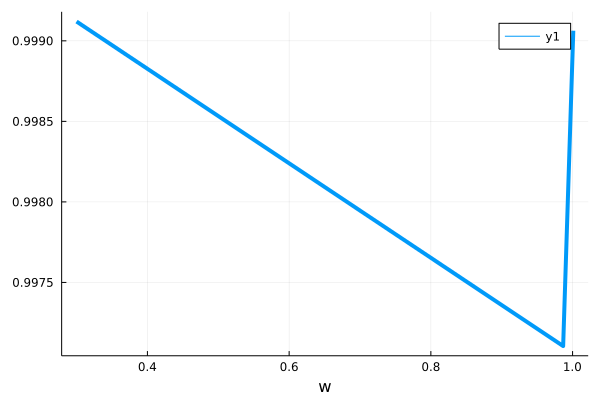

In [164]:
x, A = laplace1d(40)
ws = LinRange(.3, 1.001, 50)
radius = [opnorm(I - w*A) for w in ws]
plot(ws, radius, xlabel="w")

* The spectrum of $A$ runs from $\theta_{\min}^2$ up to 2.  If $w > 1$, then $\lVert I - w A \rVert > 1$ because the operation amplifies the high frequencies (associated with the eigenvalue of 2).
* The value of $w$ that minimizes the norm is slightly less than 1, but the convergence rate is very slow (only barely less than 1).

# Symbol of damping

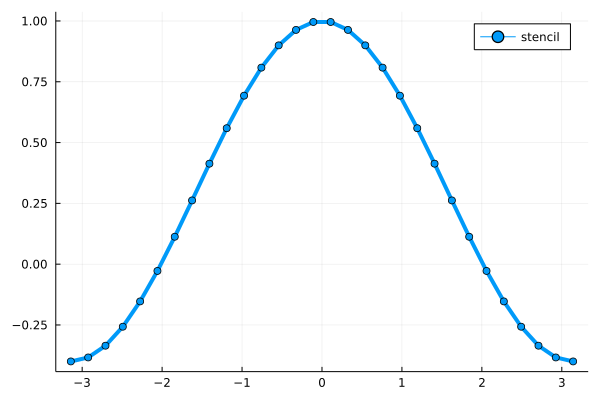

In [171]:
w = .7
plot_symbol([0 1 0] - w * [-.5 1 -.5], 0; plot_ref=false)

* Evidently it is very difficult to damp low frequencies.
* This makes sense because $A$ and $I - wA$ move information only one grid point per iteration.
* It also makes sense because the polynomial needs to be 1 at the origin, and the low frequencies have eigenvalues very close to zero.

# Coarse grids: Make low frequencies high (again)

As in domain decomposition, we will express our "coarse" subspace, consisting of a grid $x \in 2h\mathbb Z$, in terms of its interpolation to the fine space.  Here, we'll use linear interpolation.

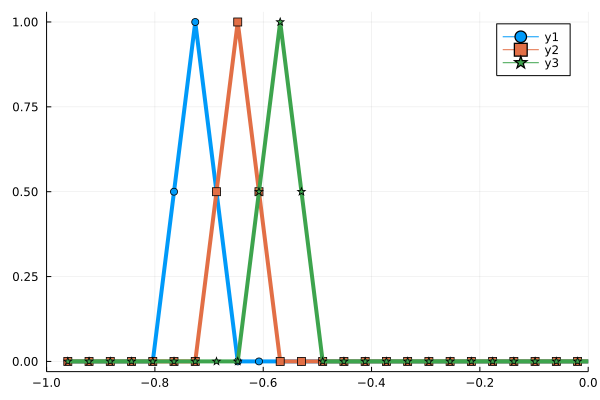

In [197]:
function interpolate(m, stride=2)
    s1 = (stride - 1) / stride
    s2 = (stride - 2) / stride
    P = diagm(0 => ones(m),
        -1 => s1*ones(m-1), +1 => s1*ones(m-1),
        -2 => s2*ones(m-2), +2 => s2*ones(m-2))
    P[:, 1:stride:end]
end
n = 50; x, A = laplace1d(n)
P = interpolate(n, 2)
plot(x, P[:, 4:6], marker=:auto, xlims=(-1, 0))

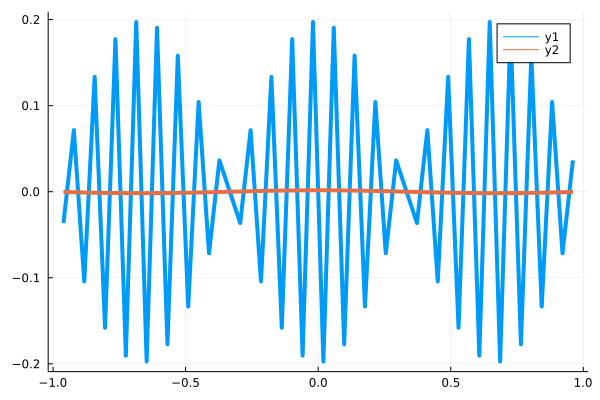

In [201]:
L, X = eigen(A)
u_h = X[:, 48]
u_2h = .5 * P' * u_h
plot(x, [u_h, P * u_2h])

# Galerkin approximation of $A$ in coarse space

$$ A_{2h} u_{2h} = P^T A_h P u_{2h} $$

size(A) = (50, 50)
size(A_2h) = (25, 25)


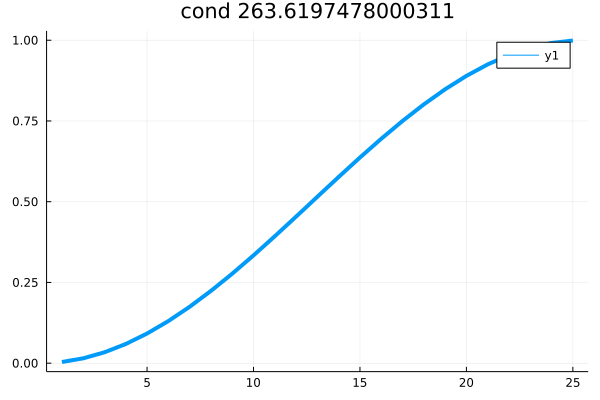

In [191]:
x, A = laplace1d(n)
P = interpolate(n)
@show size(A)
A_2h = P' * A * P
@show size(A_2h)
L_2h = eigvals(A_2h)
plot(L_2h, title="cond $(L_2h[end]/L_2h[1])")

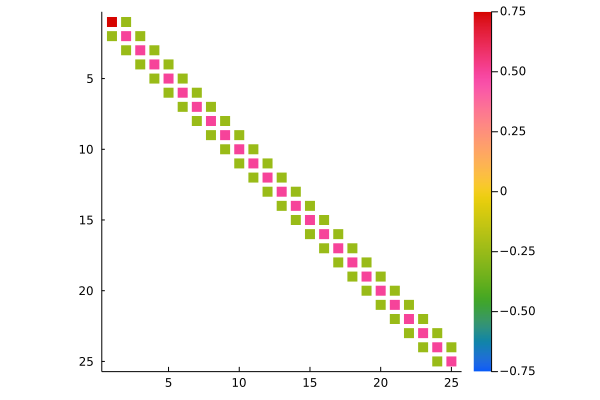

In [202]:
my_spy(A_2h)

# Coarse grid correction

Consider the $A$-orthogonal projection onto the range of $P$,
$$ S_c = P A_{2h}^{-1} P^T A $$

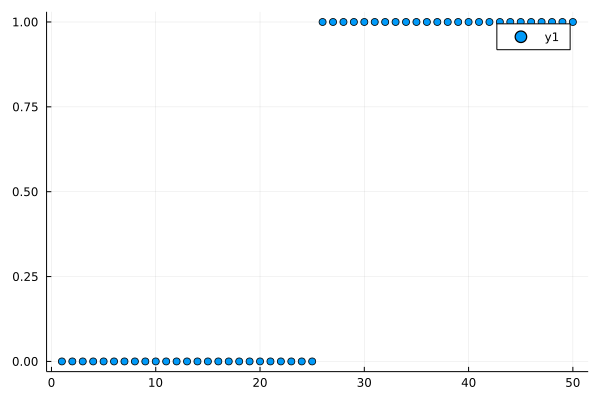

In [190]:
Sc = P * (A_2h \ P' * A)
Ls, Xs = eigen(I - Sc)
scatter(real.(Ls))

* This spectrum is typical for a projector. If $u$ is in the range of $P$, then $S_c u = u$. Why?
* For all vectors $v$ that are $A$-orthogonal to the range of $P$, we know that $S_c v = 0$. Why?

# A two-grid method

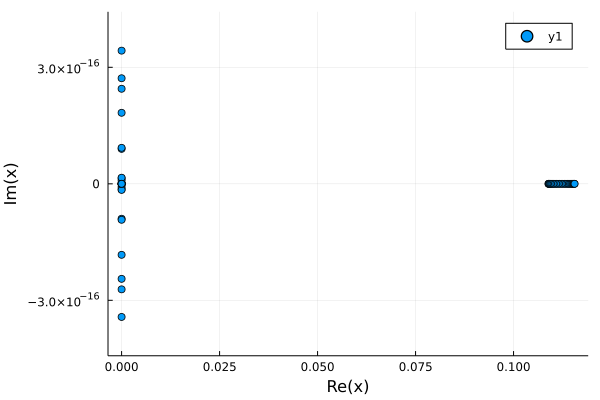

┌ Warning: No strict ticks found
└ @ PlotUtils /home/jed/.julia/packages/PlotUtils/VgXdq/src/ticks.jl:294
┌ Warning: No strict ticks found
└ @ PlotUtils /home/jed/.julia/packages/PlotUtils/VgXdq/src/ticks.jl:294


In [189]:
w = .67
T = (I - w*A) * (I - Sc) * (I - w*A)
Lt = eigvals(T)
scatter(Lt)

* Can analyze these methods in terms of frequency.
* [LFAToolkit](https://jeremylt.github.io/LFAToolkit.jl/stable/examples/diffusion/#Diffusion-operator)

# Multigrid as factorization

We can interpret factorization as a particular multigrid or domain decomposition method.

We can partition an SPD matrix as
$$A = \begin{bmatrix} F & B^T \\ B & D \end{bmatrix}$$
and define the preconditioner by the factorization
$$      M = \begin{bmatrix} I & \\ B F^{-1} & I \end{bmatrix}
      \begin{bmatrix} F &  \\ & S \end{bmatrix}
      \begin{bmatrix} I & F^{-1}B^T \\  & I \end{bmatrix}
$$
where $S = D - B F^{-1} B^T$.  $M$ has an inverse
$$
      \begin{bmatrix} I & -F^{-1}B^T \\  & I \end{bmatrix}
      \begin{bmatrix} F^{-1} &  \\ & S^{-1} \end{bmatrix}
      \begin{bmatrix} I & \\ -B F^{-1} & I \end{bmatrix} .
$$

Define the interpolation
$$ P_f = \begin{bmatrix} I \\ 0 \end{bmatrix}, \quad P_c = \begin{bmatrix} -F^{-1} B^T \\ I \end{bmatrix} $$ and rewrite as
$$ M^{-1} = [P_f\  P_c] \begin{bmatrix} F^{-1} P_f^T \\ S^{-1} P_c^T \end{bmatrix} = P_f F^{-1} P_f^T + P_c S^{-1} P_c^T.$$
The iteration matrix is thus
$$ I - M^{-1} A = I - P_f F^{-1} P_f^T J - P_c S^{-1} P_c^T A .$$

# Permute into C-F split

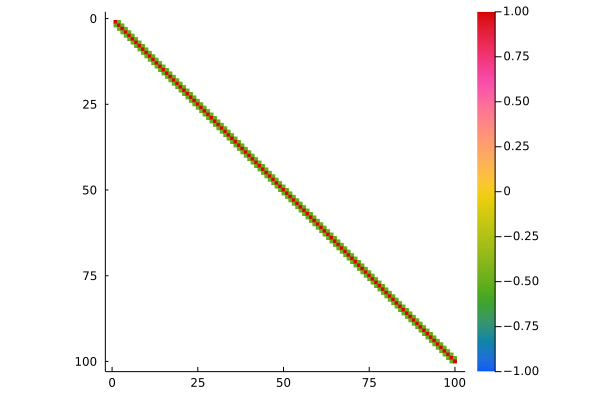

In [203]:
m = 100
x, A = laplace1d(m)
my_spy(A)

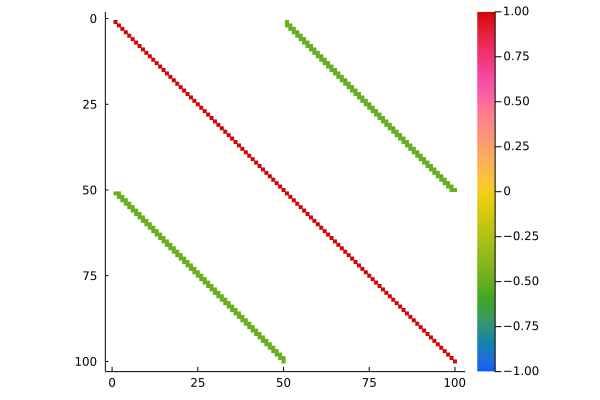

In [204]:
idx = vcat(1:2:m, 2:2:m)
J = A[idx, idx]
my_spy(J)

# Coarse basis functions

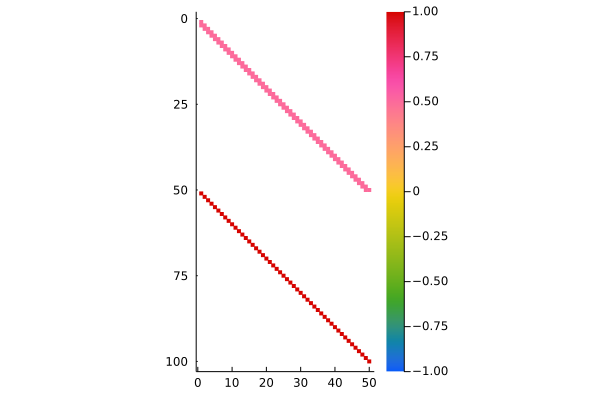

In [205]:
F = J[1:end÷2, 1:end÷2]
B = J[end÷2+1:end,1:end÷2]
P = [-F\B'; I]
my_spy(P)

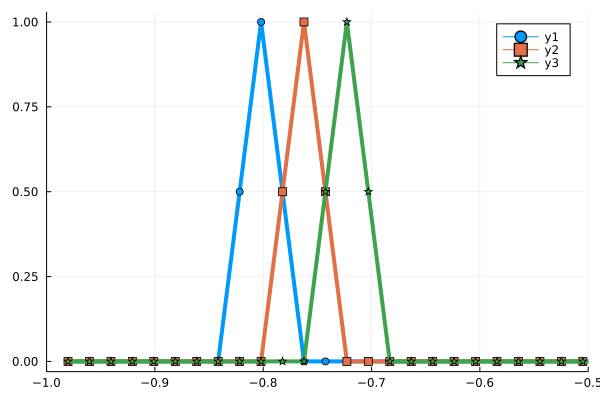

In [206]:
idxinv = zeros(Int64, m)
idxinv[idx] = 1:m
Pp = P[idxinv, :]
plot(x, Pp[:, 5:7], marker=:auto, xlims=(-1, -.5))

# From factorization to algebraic multigrid

* Factorization as a multigrid (or domain decomposition) method incurs significant cost in multiple dimensions due to lack of sparsity.
  * We can't choose enough coarse basis functions so that $F$ is diagonal, thereby making the minimal energy extension $-F^{-1} B^T$ sparse.

* Algebraic multigrid
  * Use matrix structure to aggregate or define C-points
  * Create an interpolation rule that balances sparsity with minimal energy

# Aggregation

Form aggregates from "strongly connected" dofs.

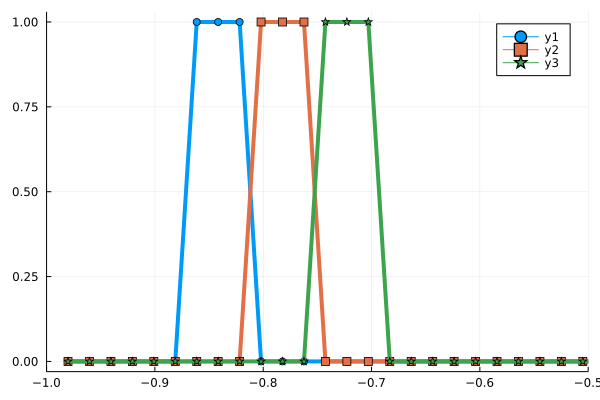

In [215]:
agg = 1 .+ (0:m-1) .÷ 3
mc = maximum(agg)
T = zeros(m, mc)
for (i, j) in enumerate(agg)
    T[i,j] = 1
end
plot(x, T[:, 3:5], marker=:auto, xlims=(-1, -.5))

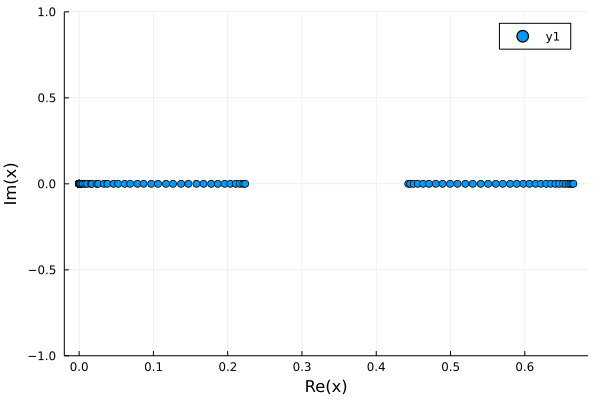

In [227]:
Sc = T * ((T' * A * T) \ T') * A
w = .67; k = 1
E = (I - w*A)^k * (I - Sc) * (I - w*A)^k
scatter(eigvals(E), ylims=(-1, 1))

* simple and cheap method
* stronger smoothing (bigger `k`) doesn't help much; need more accurate coarse grid

# Smoothed aggregation

$$ P = (I - w A) T $$

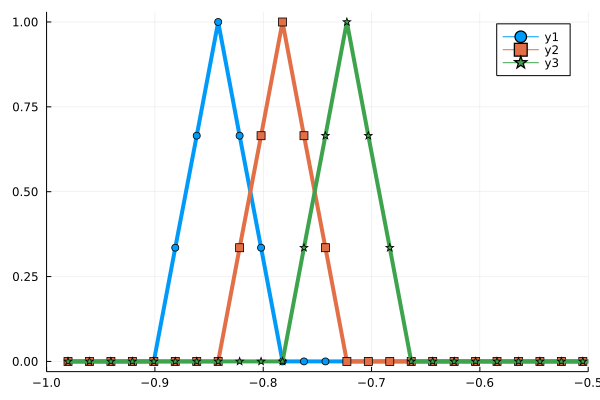

In [229]:
P = (I - w * A) * T
plot(x, P[:, 3:5], marker=:auto, xlims=(-1,-.5))

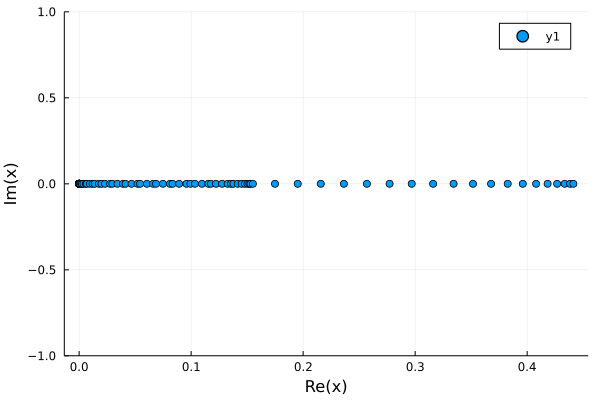

In [232]:
Sc = P * ((P' * A * P) \ P') * A
w = .67; k = 1
E = (I - w*A)^k * (I - Sc) * (I - w*A)^k
scatter(eigvals(E), ylims=(-1, 1))

* Eigenvalues are closer to zero; stronger smoothing (larger `k`) helps.
* Smoother can be made stronger using Chebyshev (like varying the damping between iterations in Jacobi)